In [1]:
%matplotlib inline

import time
from multiprocessing import Pool
from multiprocessing import cpu_count
from PRD_h_f2 import hf
import numpy as np
import matplotlib.pyplot as plt


from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
import pycbc.psd
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.waveform import td_approximants, fd_approximants

In [2]:
sampFreq = 2**11              #采样频率(Sampling frequency)，单位时间样本点个数，应大于 2f（即Nyquist频率)
duration = 2**0               #信号持续时间(duration of signal) 2^16, 0.75d, 2^25 ,1.06yr


n = int(duration * sampFreq)#采样点数(Sampling Number), 有时也称为信号长度(Length of Signal) 2^16
                            #为2的幂时，快速傅里叶变化效率最高
                            #n =  duration * sampFreqint = (duration / sampIntrvl)

sampIntrvl = 1.0 / sampFreq                   #采样周期(Sampling period)，隔多少时间取样一次，或步长
freqIntrvl = sampFreq / n                     #傅里叶变换 频率分辨率(Frequency Interval) 
                                              # freqIntrvl = 1 / duration = 1 / (n * sampIntrvl)
                                              #            = sampFreq / n  
        

f_max = sampFreq/2             #信号模式的最大频率

print("采样频率为%fHz，信号持续时间%fs, 时域信号采样%d 个点"%(sampFreq,duration,n))
print("信号中可分析最大频率为%fHz"%f_max)
print("\n采样周期，即时域分辨率为%fs"%(sampIntrvl))
print("信号频域的频率间隔，即频域分辨率为%fHz"%freqIntrvl);

采样频率为2048.000000Hz，信号持续时间1.000000s, 时域信号采样2048 个点
信号中可分析最大频率为1024.000000Hz

采样周期，即时域分辨率为0.000488s
信号频域的频率间隔，即频域分辨率为1.000000Hz


In [3]:
#列出频率波形
low_frequency_cutoff = 20                     #截止频率

#print(fd_approximants())

hpf, hcf = get_fd_waveform(approximant="IMRPhenomPv2",
                             mass1=10, mass2=10, delta_f=freqIntrvl,distance = 100, f_lower=low_frequency_cutoff)

#distance = 100 Mpc

print((hpf.sample_frequencies))

hp = hpf.to_timeseries()
hc = hcf.to_timeseries()

[0.000e+00 1.000e+00 2.000e+00 ... 2.046e+03 2.047e+03 2.048e+03]


In [4]:
core = cpu_count()
print("cores = %d"%core)

ntol = 16
#Variables
                  
f = np.linspace(low_frequency_cutoff, 512, ntol + 1);      #(* GW or Fourier \frequency *)
print(f)
f = f.tolist()

cores = 8
[ 20.    50.75  81.5  112.25 143.   173.75 204.5  235.25 266.   296.75
 327.5  358.25 389.   419.75 450.5  481.25 512.  ]


In [5]:
time0 = time.time()
with Pool() as pool:
    hans_f = pool.map(hf, f)
timet = time.time()
print("cost %4.1fs"%(timet-time0))

cost 152.3s


In [6]:
freqIntrvl2 = f[1]-f[0]
htol_f = FrequencySeries(hans_f, delta_f=freqIntrvl2, epoch='', dtype=None, copy=True)
htol = htol_f.to_timeseries()

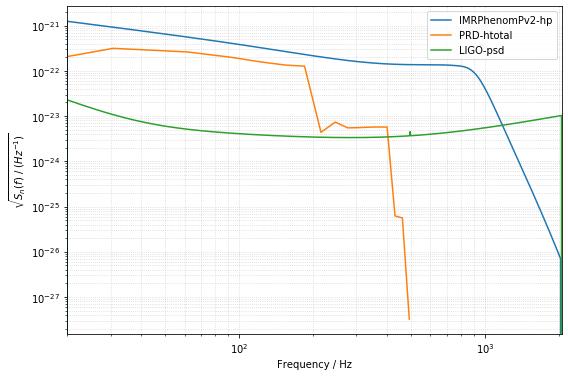

In [7]:
# 列出lalsuite内置的解析psd (没发现有LISA的，下面以LIGO的作为示例)
#print(pycbc.psd.get_lalsim_psd_list())


#示例，psd参见， https://dcc.ligo.org/LIGO-T1800044/public

psd = pycbc.psd.from_string('aLIGOaLIGODesignSensitivityT1800044', n, freqIntrvl, low_frequency_cutoff)

#绘制 频率 - sqrt(PSD) 图
plt.figure(figsize=(8,8/1.5))
plt.loglog(hpf.sample_frequencies, 2 * np.sqrt(hpf.sample_frequencies) * abs(hpf), label = 'IMRPhenomPv2-hp')
plt.loglog(htol_f.sample_frequencies, 2 * np.sqrt(htol_f.sample_frequencies) * abs(htol_f), label = 'PRD-htotal')
plt.loglog(psd.sample_frequencies, np.sqrt(psd), label = 'LIGO-psd')
plt.xlim(20,2048)
plt.xlabel("Frequency / Hz")
plt.ylabel("$\sqrt{S_{n}(f) \ / \ (Hz^{-1})}$")
plt.legend()
plt.tight_layout()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.show()

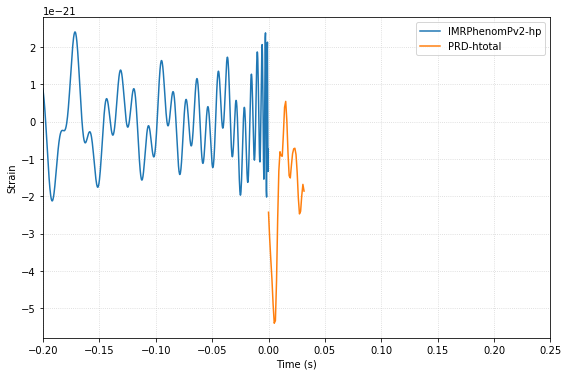

In [8]:
# hp, hc = get_td_waveform(approximant="IMRPhenomPv2",
#                              mass1=6, mass2=6, delta_t =sampIntrvl, f_lower=low_frequency_cutoff)

plt.figure(figsize=(8,8/1.5))
plt.plot(hp.sample_times, hp, label='IMRPhenomPv2-hp')
# plt.plot(hc.sample_times, hc, label='IMRPhenomPv2-hc')
plt.plot(htol.sample_times, htol, label='PRD-htotal')
plt.xlim(-0.2,0.25)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.tight_layout()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.show()